In [70]:
import pylcp
import numpy as np
import scipy.constants as cts
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from celluloid import Camera
from IPython.display import HTML
from multiprocessing import Pool
import pymongo

# Define the parameters and functions

In [8]:
#Define the constants
main_detune = 17
sideband_detune = 120
white_detune = 10
laser_on = 200000
laser_off = 400015
MOT_power = 50
v0_start=1
v0_step=1
v0_end=25
t0_start=0
t0_step=1
t0_end=3500000

Gamma = 22 # Hz to kHz, Decay rate
wavelength = 359.3e-9 # m to mm
k = 1/wavelength*2*np.pi #x_0
x0 = 1/k
t0 = 1/Gamma*1/(2*np.pi*1e6)
v0 = x0/t0
m0 = cts.hbar*t0/x0**2
a0 = x0/t0**2
F0 = cts.hbar/(x0*t0)
mass = 43*cts.value('atomic mass constant')/m0 # m_0
waist = 0.012/x0
v_max = 8.
z_max = 0.012/x0
z_start = 0.012/x0
omega = 2*np.pi*(cts.c/wavelength) #Transition frequency
Isat = np.pi*cts.h*cts.c*Gamma*2*np.pi*1e6/3*1/(wavelength)**3
t_eval = np.arange(t0_start,t0_end,t0_step)

# The detunings used in the PRAs:
intensities = 2.*MOT_power*1e-3/(np.pi*0.012**2)/Isat

#Define the hamiltonian
H0_X, Bq_X, U_X, Xbasis = pylcp.hamiltonians.XFmolecules.Xstate(N=1,I=0.5,B=15496.8125/Gamma,
gamma = 50.697/Gamma,b=154.7/Gamma, c=178.5/Gamma,gI=5.585,gS=2.0023193043622,
    muB = cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    muN=cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')*1e-4*1e-6/Gamma,return_basis=True
    )

# b : SI coupling(isotropic), c : Iz Sz coupling(anisotropic), cc : I N coupling, gamma : S N coupling

E_X = np.unique(np.diag(H0_X))

H0_A, Bq_A, Abasis = pylcp.hamiltonians.XFmolecules.Astate(J=0.5,I=0.5,
    P=+1,B=15788.2/Gamma,D=0.,H=0.,a=109./Gamma,b=-299.2/Gamma,c=274.2/Gamma,q=0., p=15./Gamma,
    muB=cts.value('Bohr magneton in Hz/T')/1e6*1e-4/Gamma,
    muN=cts.m_e/cts.m_p*cts.value('Bohr magneton in Hz/T')*1e-4*1e-6/Gamma,
    gl=53/(2*15788.2),glprime=15/(2*15788.2),greprime=0.,return_basis=True
    )

# gJ : Lande g-factor, p : parity(e parity)

E_A = np.unique(np.diag(H0_A))

dijq = pylcp.hamiltonians.XFmolecules.dipoleXandAstates(
    Xbasis, Abasis, UX=U_X
    )

hamiltonian = pylcp.hamiltonian(H0_X, H0_A, Bq_X, Bq_A, dijq,mass = mass)

In [71]:
def Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    pX = (p1+p2+p3+p4)/4
    pp1 = p1 - pX
    pp2 = p2 - pX
    pp3 = p3- pX
    pp4 = p4 - pX
    
    def intensity_res(pp):
        intensity_norm = 0.050
        other = 2.*(intensity_norm+pp/(10**3))/(np.pi*(0.012)**2)/Isat
        return other
    
    def sigmoid_function(x):
        if (1/(1+np.exp(-1*x))*2)//1 == 1.:
            return +1
        else:
            return -11
    
    laserBeams = pylcp.laserBeams()
    for ii, Eg_i in enumerate(E_X):
        if ii<1:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp1), delta=(E_A[-1] - Eg_i)+d1,pol=sigmoid_function(pol1),wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        elif ii==1:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp2), delta=(E_A[-1] - Eg_i)+d2,pol=sigmoid_function(pol2),wb=waist,
                beam_type=pylcp.gaussianBeam)
        elif ii==2:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp3), delta=(E_A[-1] - Eg_i)+d3,pol=sigmoid_function(pol3),wb=waist,
                beam_type=pylcp.gaussianBeam
                )
        else:
            laserBeams += pylcp.conventional3DMOTBeams(
                s=intensity_res(pp4), delta=(E_A[-1] - Eg_i)+d4,pol=sigmoid_function(pol4),wb=waist,
                beam_type=pylcp.gaussianBeam
                )

    return laserBeams

In [72]:
from pymongo import MongoClient

connection = MongoClient("mongodb://localhost:27017")
vc = connection.db.New_vc

In [73]:
max_parameters = vc.find(limit=5,projection={"_id" : 0}).sort("target",pymongo.DESCENDING)

for r in max_parameters:
    print(r["params"])

{'Bgrad': 1.4042238616515523, 'd1': -2.2588781363386063, 'd2': 0.09074869908483722, 'd3': -1.2205504343708002, 'd4': 0.971145047973011, 'p1': 11.762553214962567, 'p2': 5.290013650268243, 'p3': 30.50970407456675, 'p4': 20.465288342448723, 'pol1': -0.7634108984711113, 'pol2': 0.46967967537228744, 'pol3': -0.7807936290951054, 'pol4': 0.7314819459604724, 'v0s': 5.988269600338705}
{'Bgrad': 1.4775158889881894, 'd1': -2.593952648688282, 'd2': 0.09499502278772876, 'd3': -1.3749744334642233, 'd4': 0.6859921868223319, 'p1': 12.295797814107132, 'p2': 5.2060765055801275, 'p3': 30.85691845562161, 'p4': 20.387213154418877, 'pol1': -0.6079072694139378, 'pol2': 0.46111767196043524, 'pol3': -0.7908606254558785, 'pol4': 0.550849693298431, 'v0s': 5.928440276876206}
{'Bgrad': 0.8271881116281732, 'd1': -2.9999916139249083, 'd2': 0.9999979647374173, 'd3': -0.5275457446826719, 'd4': -1.8608524723382682, 'p1': 46.53430166576468, 'p2': 25.481441758312357, 'p3': 23.36833011215683, 'p4': 29.063192214804765, 'po

#### Max transverse position with $v_z = 0$ : $4\ \rm{mm}$
#### Max transvser velocity with $z=0$ : $12.6476\ \mathrm{m/s} \sim 1.6 \Gamma/k$
#### $v_c = 6.12\ \Gamma/k$

#### Capture velocity at $z=12\ \rm{mm}$ : $1.83638\ \Gamma/k$

Make the range of ($z,v_z,v_c$) : ($0\ \mathrm{mm},1.6\ \Gamma/k,6.12\ \Gamma/k$) to ($12\ \mathrm{mm},0\ \Gamma/k,1.83638\ \Gamma/k$)

# Build the mechanism

In [74]:
def if_trapped(z,vz,vc,v0s,Bgrad,d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    def trap_condition(t,y):
        if abs(y[-3])*1000*x0<6 and abs(y[-6])<5e-2 and abs(y[-2])*1000*x0<6 and abs(y[-5])<5e-2 and abs(y[1])*x0*1000<6 and abs(y[-4])<5e-2:
            val = -1.
        else:
            val = 1.
        return val
    
    def lost_condition(t,y):
        if abs(y[-3])*1000*x0>13 or abs(y[-2])*1000*x0>13:
            val = -1.
        else:
            val=1.
        return val
    trap_condition.terminal = True
    lost_condition.terminal = True
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField = pylcp.quadrupoleMagneticField(Bgrad*x0*1000)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    
    eqn.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,z/x0*1e-3]),np.array([vc,vc,vz]))
    eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

    eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= [trap_condition,lost_condition],progress_bar = 0,method='LSODA',max_step=2e5)
    sol = eqn.sol

    if len(sol.t_events[0])==1:
        return 1
    elif len(sol.t_events[1])==1:
        return -1
    else:
        return 0.

In [75]:
z_range = np.linspace(0,12,13)
vz_range = np.linspace(0,3,13)
vc_range = np.linspace(1,7,13)

Z,VZ,VC = np.meshgrid(z_range,vz_range,vc_range,sparse = 1,indexing='xy')

it = np.nditer([Z,VZ,VC],flags = ["refs_ok","multi_index"],op_flags = ["readonly","readonly"])



In [76]:
from Multiprocessing import *

In [77]:
import Multiprocessing

In [79]:
import importlib

importlib.reload(Multiprocessing)

<module 'Multiprocessing' from 'd:\\migration\\MgF-simulation\\Multiprocessing.py'>

In [80]:
start = time.time()

def data_stream(a, b, c):
    for i, av in enumerate(a):
        for j, bv in enumerate(b):
            for kk, cv in enumerate(c):
                yield (i, j, kk), (av, bv, cv)


with Pool(15) as pool:
    result = pool.map(Multiprocessing.approx, data_stream(z_range,vz_range,vc_range))
    pool.close()
    pool.join()

print(time.time()-start)

4038.269106864929


In [85]:
Result_array = np.zeros((1,13,13,13))

for ii,jj in result:
    Result_array[0][ii] = jj


In [88]:
other_array = Result_array.copy()

for ii in range(len(z_range)):
    for jj in range(len(vz_range)):
        for kk in range(len(vc_range)):
            if kk==0:
                continue
            else:
                if other_array[0][ii,jj,kk-1] == -1:
                    other_array[0][ii,jj,kk]=-1

Text(0.5, 0, '$v_c\\ \\mathrm{(m/s)}$')

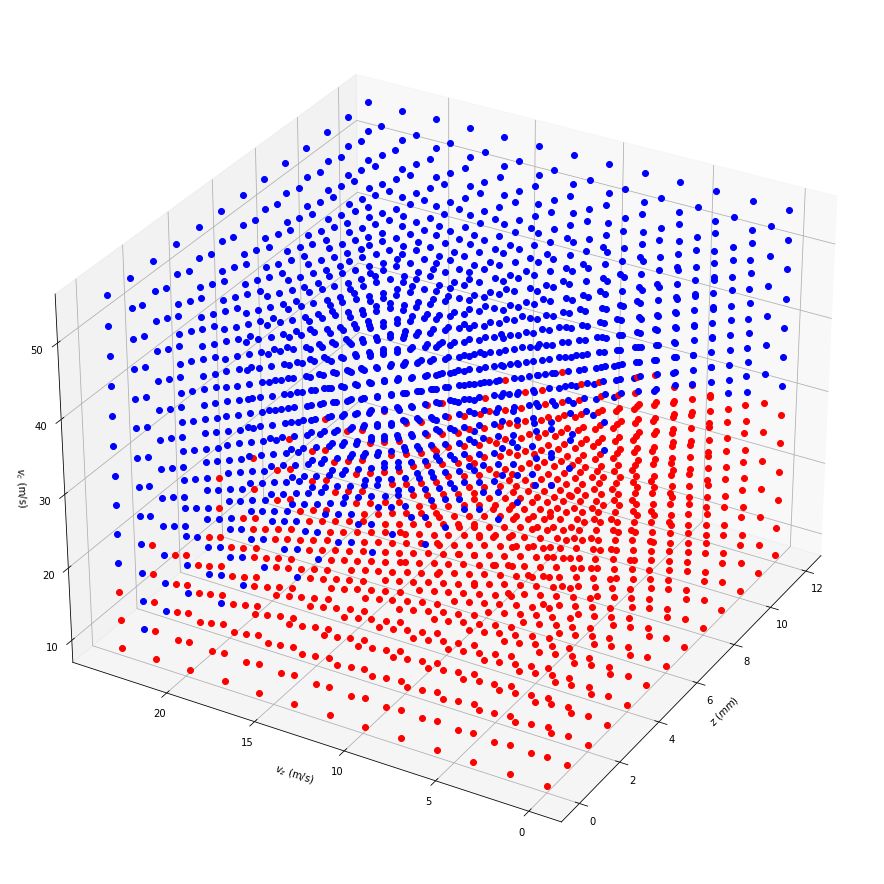

In [86]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(projection = '3d')

camera = Camera(fig)

def color_func(i,j,k):
    if Result_array[0,i,j,k]==1.:
        return 'red'
    elif Result_array[0,i,j,k]==-1.:
        return 'blue'
    else:
        return 'yellow'

for ii,z in enumerate(z_range):
    for jj, vz in enumerate(vz_range):
        for kk, vc in enumerate(vc_range):
            ax.plot(z,vz*v0,vc*v0,'o',color = color_func(ii,jj,kk))
    camera.snap()
            
n = 0
ax.view_init(30,210)
ax.set_xlabel("$z$ ($mm$)")
ax.set_ylabel("$v_z\ \mathrm{(m/s)}$")
ax.set_zlabel("$v_c\ \mathrm{(m/s)}$")
# ax.set_xlim(1.2*(n-0.1),1.2*(n+0.1))
# fig.savefig("./MOT/VC_3D scatter.png")
# fig.savefig("./MOT/Vc_3D exception.png")

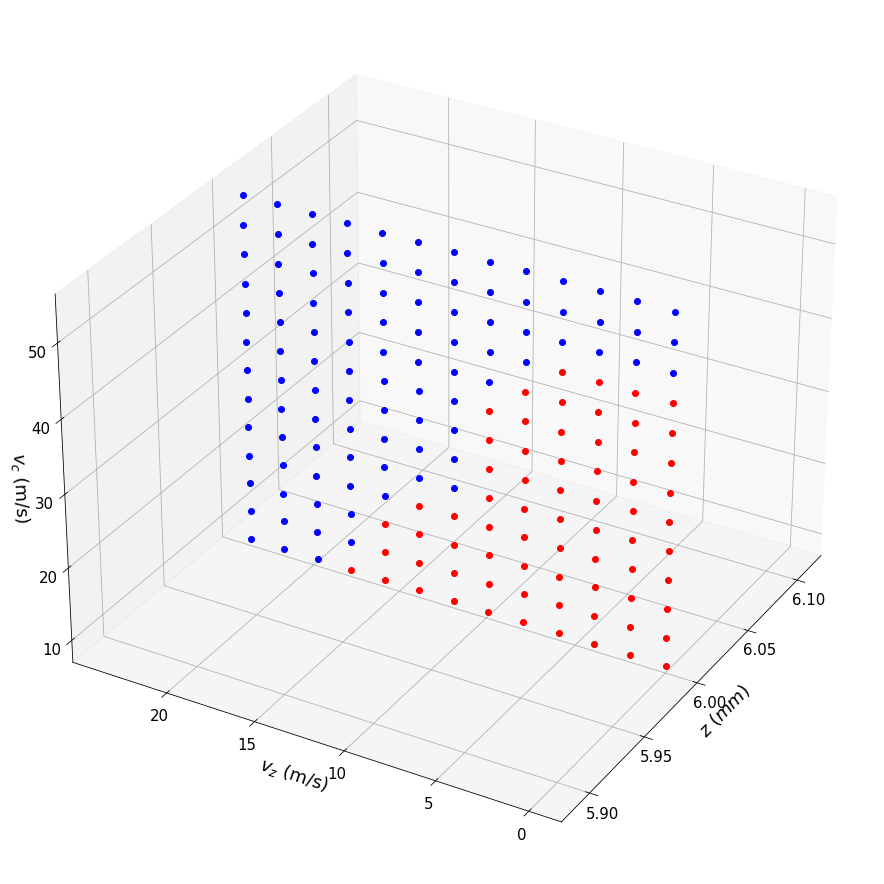

In [100]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(projection = '3d')

camera = Camera(fig)

def color_func(i,j,k):
    if other_array[0,i,j,k]==1.:
        return 'red'
    elif other_array[0,i,j,k]==-1.:
        return 'blue'
    else:
        return 'yellow'

for ii,z in enumerate(z_range):
    for jj, vz in enumerate(vz_range):
        for kk, vc in enumerate(vc_range):
            ax.plot(z,vz*v0,vc*v0,'o',color = color_func(ii,jj,kk))
    camera.snap()
            
n = 5
ax.view_init(30,210)
ax.set_xlabel("$z$ ($mm$)",fontsize=18)
ax.set_ylabel("$v_z\ \mathrm{(m/s)}$",fontsize=18)
ax.set_zlabel("$v_c\ \mathrm{(m/s)}$",fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.tick_params(axis='z', labelsize=15)
ax.set_xlim(1.2*(n-0.1),1.2*(n+0.1))
# fig.savefig("./MOT/VC_3D scatter.png")
fig.savefig("./MOT/Vc_3D exception.png")

In [90]:
animation = camera.animate(interval=500, blit=False)

from IPython.display import HTML
HTML(animation.to_jshtml())

In [103]:
animation.save("./MOT/3D_scatter_plot_0624_1.gif")

In [104]:
np.save("D:/migration/VC_finding_array_0624",Result_array)

# To plot the motion trace in specific condition

In [ ]:
def trans_condition_plot(z,vz,vc,v0s,Bgrad,d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    zz = np.linspace(-1*z_max,z_max,100)
    vv = np.linspace(-1*v_max,v_max,100)
    Z,V = np.meshgrid(zz,vv)
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField=pylcp.quadrupoleMagneticField(Bgrad*x0*1000)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    eqn.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)
    eqn.generate_force_profile([np.zeros(Z.shape),Z,np.zeros(Z.shape)],[np.zeros(V.shape),V,np.zeros(V.shape)],name='Fy',progress_bar=1)
    eqn.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='Fz',progress_bar=1)

    def trap_condition(t,y):
        if abs(y[-3])*1000*x0<2 and abs(y[-6])<5e-2 and abs(y[-2])*1000*x0<2 and abs(y[-5])<5e-2:
            val = -1.
        else:
            val = 1.
        return val
    
    def lost_condition(t,y):
        if y[-3]*1000*x0>12 or y[-2]*1000*x0>12:
            val = -1.
        else:
            val=1.
        return val
    
    trap_condition.terminal = True
    lost_condition.terminal = True
    
    eqn.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,z/x0*1e-3]),np.array([vc,vc,vz]))
    eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

    eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= [trap_condition,lost_condition],progress_bar = 1,method='LSODA',max_step=2e5)
    sol = eqn.sol
    
    fig,ax = plt.subplots(1,3,figsize=(20,4))
    
    imx = ax[0].imshow(eqn.profile['Fx'].F[0]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbx = plt.colorbar(imx,ax = ax[0])
    cbx.set_label('$a (\mathrm{km/s^2})$')
    
    imy = ax[1].imshow(eqn.profile['Fy'].F[1]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cby = plt.colorbar(imy,ax = ax[1])
    cby.set_label('$a (\mathrm{km/s^2})$')

    imz = ax[2].imshow(eqn.profile['Fz'].F[2]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbz = plt.colorbar(imz,ax = ax[2])
    cbz.set_label('$a (\mathrm{km/s^2})$')

    ax[2].set_xlabel('$z (\mathrm{mm})$')
    ax[2].set_ylabel('$v (\mathrm{m/s})$')
    ax[2].set_title('Z axis force image')
    ax[2].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[2].set_ylim(-1*v_max*v0,1*v_max*v0)

    ax[0].set_xlabel('$x (\mathrm{mm})$')
    ax[0].set_ylabel('$v (\mathrm{m/s})$')
    ax[0].set_title('X axis force image')
    ax[0].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[0].set_ylim(-1*v_max*v0,1*v_max*v0)
    
    ax[1].set_xlabel('$y (\mathrm{mm})$')
    ax[1].set_ylabel('$v (\mathrm{m/s})$')
    ax[1].set_title('Y axis force image')
    ax[1].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[1].set_ylim(-1*v_max*v0,1*v_max*v0)
    fig.subplots_adjust(left=0.12,right=0.9)
    
    print(eqn.sol.v[0][-1], eqn.sol.r[0][-1])
    
    ax[0].plot(sol.r[0]*x0*1000,sol.v[0]*v0,color='black')
    ax[1].plot(sol.r[1]*x0*1000,sol.v[1]*v0,color='black')
    ax[2].plot(sol.r[2]*x0*1000,sol.v[2]*v0,color='black')
    # print(sol.v[0][0]*v0, sol.v[1][0]*v0)
#     ax.plot(eqn.sol.r[0]*x0*1000,v0*v0s*np.ones(len(eqn.sol.r[0])),'g')
    # fig.savefig('./MOT/bayes_trans_condition_0422.png')
    

In [ ]:
def trans_condition_plot(z,vz,vc,v0s,Bgrad,d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    zz = np.linspace(-1*z_max,z_max,100)
    vv = np.linspace(-1*v_max,v_max,100)
    Z,V = np.meshgrid(zz,vv)
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField=pylcp.quadrupoleMagneticField(Bgrad*x0*1000)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    eqn.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)
    eqn.generate_force_profile([np.zeros(Z.shape),Z,np.zeros(Z.shape)],[np.zeros(V.shape),V,np.zeros(V.shape)],name='Fy',progress_bar=1)
    eqn.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='Fz',progress_bar=1)

    def trap_condition(t,y):
        if abs(y[-3])*1000*x0<2 and abs(y[-6])<5e-2 and abs(y[-2])*1000*x0<2 and abs(y[-5])<5e-2:
            val = -1.
        else:
            val = 1.
        return val
    
    def lost_condition(t,y):
        if y[-3]*1000*x0>13 or y[-2]*1000*x0>30:
            val = -1.
        else:
            val=1.
        return val
    
    trap_condition.terminal = True
    lost_condition.terminal = True
    
    eqn.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,z/x0*1e-3]),np.array([vc,vc,vz]))
    eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

    eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= [trap_condition,lost_condition],progress_bar = 1,method='LSODA',max_step=2e5)
    sol = eqn.sol
    
    fig,ax = plt.subplots(1,3,figsize=(20,4))
    camera = Camera(fig)
    
    imx = ax[0].imshow(eqn.profile['Fx'].F[0]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbx = plt.colorbar(imx,ax = ax[0])
    cbx.set_label('$a (\mathrm{km/s^2})$')
    
    imy = ax[1].imshow(eqn.profile['Fy'].F[1]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cby = plt.colorbar(imy,ax = ax[1])
    cby.set_label('$a (\mathrm{km/s^2})$')

    imz = ax[2].imshow(eqn.profile['Fz'].F[2]*a0/mass*1e-3, origin='lower',
           extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
                   np.amin(vv*v0), np.amax(vv*v0)),
           aspect='auto',cmap='RdBu')
    cbz = plt.colorbar(imz,ax = ax[2])
    cbz.set_label('$a (\mathrm{km/s^2})$')


    ax[2].set_xlabel('$z (\mathrm{mm})$')
    ax[2].set_ylabel('$v (\mathrm{m/s})$')
    ax[2].set_title('Z axis force image')
    ax[2].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[2].set_ylim(-1*2.5*v0,1*2.5*v0)

    ax[0].set_xlabel('$x (\mathrm{mm})$')
    ax[0].set_ylabel('$v (\mathrm{m/s})$')
    ax[0].set_title('X axis force image')
    ax[0].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[0].set_ylim(-1*v_max*v0,1*v_max*v0)
    
    ax[1].set_xlabel('$y (\mathrm{mm})$')
    ax[1].set_ylabel('$v (\mathrm{m/s})$')
    ax[1].set_title('Y axis force image')
    ax[1].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[1].set_ylim(-1*v_max*v0,1*v_max*v0)
    fig.subplots_adjust(left=0.12,right=0.9)
    
    print(eqn.sol.v[0][-1], eqn.sol.r[0][-1],len(sol.t))
    
    ax[0].plot(sol.r[0]*x0*1000,sol.v[0]*v0,color='black')
    ax[1].plot(sol.r[1]*x0*1000,sol.v[1]*v0,color='black')
    ax[2].plot(sol.r[2]*x0*1000,sol.v[2]*v0,color='black')
    # print(sol.v[0][0]*v0, sol.v[1][0]*v0)
#     ax.plot(eqn.sol.r[0]*x0*1000,v0*v0s*np.ones(len(eqn.sol.r[0])),'g')
    # fig.savefig('./MOT/trans_condition_0422_'+f"{z},{vz},{vc}.png")
    

In [ ]:
trans_condition_plot(z_range[0],vz_range[-3],vc_range[-2],**max_parameters[0])

In [ ]:
Result_array[0][0,-3,-2]

In [ ]:
trans_condition_plot(z_range[0],vz_range[-1],vc_range[0],**max_parameters[0])

In [ ]:
Result_array[0][0,-1,0]

In [ ]:
print(vc_range[-5:-2])

In [ ]:
def trans_condition_gif(z,vz,vc,v0s,Bgrad,d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    zz = np.linspace(-1*z_max,z_max,100)
    vv = np.linspace(-1*v_max,v_max,100)
    Z,V = np.meshgrid(zz,vv)
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField=pylcp.quadrupoleMagneticField(Bgrad*x0*1000)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    # eqn.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)
    # eqn.generate_force_profile([np.zeros(Z.shape),Z,np.zeros(Z.shape)],[np.zeros(V.shape),V,np.zeros(V.shape)],name='Fy',progress_bar=1)
    # eqn.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='Fz',progress_bar=1)

    def trap_condition(t,y):
        if abs(y[-3])*1000*x0<2 and abs(y[-6])<5e-2 and abs(y[-2])*1000*x0<2 and abs(y[-5])<5e-2:
            val = -1.
        else:
            val = 1.
        return val
    
    def lost_condition(t,y):
        if y[-3]*1000*x0>30 or y[-2]*1000*x0>30:
            val = -1.
        else:
            val=1.
        return val
    
    trap_condition.terminal = True
    lost_condition.terminal = True
    
    eqn.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,z/x0*1e-3]),np.array([vc,vc,vz]))
    eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

    eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= [trap_condition,lost_condition],progress_bar = 1,method='LSODA',max_step=2e5)
    sol = eqn.sol
    
    fig,ax = plt.subplots(1,3,figsize=(20,4))
    camera = Camera(fig)
    
#     imx = ax[0].imshow(eqn.profile['Fx'].F[0]*a0/mass*1e-3, origin='lower',
#            extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
#                    np.amin(vv*v0), np.amax(vv*v0)),
#            aspect='auto',cmap='RdBu')
#     cbx = plt.colorbar(imx,ax = ax[0])
#     cbx.set_label('$a (\mathrm{km/s^2})$')
    
#     imy = ax[1].imshow(eqn.profile['Fy'].F[1]*a0/mass*1e-3, origin='lower',
#            extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
#                    np.amin(vv*v0), np.amax(vv*v0)),
#            aspect='auto',cmap='RdBu')
#     cby = plt.colorbar(imy,ax = ax[1])
#     cby.set_label('$a (\mathrm{km/s^2})$')

#     imz = ax[2].imshow(eqn.profile['Fz'].F[2]*a0/mass*1e-3, origin='lower',
#            extent=(np.amin(zz*x0*1000), np.amax(zz*x0*1000),
#                    np.amin(vv*v0), np.amax(vv*v0)),
#            aspect='auto',cmap='RdBu')
#     cbz = plt.colorbar(imz,ax = ax[2])
#     cbz.set_label('$a (\mathrm{km/s^2})$')


    ax[2].set_xlabel('$z (\mathrm{mm})$')
    ax[2].set_ylabel('$v (\mathrm{m/s})$')
    ax[2].set_title('Z axis force image')
    ax[2].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[2].set_ylim(-1*2.5*v0,1*2.5*v0)

    ax[0].set_xlabel('$x (\mathrm{mm})$')
    ax[0].set_ylabel('$v (\mathrm{m/s})$')
    ax[0].set_title('X axis force image')
    ax[0].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[0].set_ylim(-1*v_max*v0,1*v_max*v0)
    
    ax[1].set_xlabel('$y (\mathrm{mm})$')
    ax[1].set_ylabel('$v (\mathrm{m/s})$')
    ax[1].set_title('Y axis force image')
    ax[1].set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax[1].set_ylim(-1*v_max*v0,1*v_max*v0)
    fig.subplots_adjust(left=0.12,right=0.9)
    
    print(eqn.sol.v[0][-1], eqn.sol.r[0][-1],len(sol.t))
    time_steps = np.linspace(0,1000000,101)
    
    for time_step in tqdm(time_steps):
        ts = int(time_step)
        ax[0].plot(sol.r[0][ts]*x0*1000,sol.v[0][ts]*v0,"ro")
        ax[1].plot(sol.r[1][ts]*x0*1000,sol.v[1][ts]*v0,"ro")
        ax[2].plot(sol.r[2][ts]*x0*1000,sol.v[2][ts]*v0,"ro")
        camera.snap()
        
    animation = camera.animate(interval=100, blit=False)
    # HTML(animation.to_jshtml())
    animation.save("./MOT/3D_scatter"+f"{z},{vz},{vc}.gif",dpi=100, writer="imagemagick")
    # print(sol.v[0][0]*v0, sol.v[1][0]*v0)
#     ax.plot(eqn.sol.r[0]*x0*1000,v0*v0s*np.ones(len(eqn.sol.r[0])),'g')
    # fig.savefig('./MOT/trans_condition_0422_'+f"{z},{vz},{vc}.png")
    

In [ ]:
trans_condition_gif(z_range[1],vz_range[1],vc_range[-5],**max_parameters[0])

In [ ]:
def trans_condition_gif_3D(z,vz,vc,v0s,Bgrad,d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4):
    zz = np.linspace(-1*z_max,z_max,100)
    vv = np.linspace(-1*v_max,v_max,100)
    Z,V = np.meshgrid(zz,vv)
    
    laserBeams = Fixed_detune_MgF_MOT(d1,d2,d3,d4,p1,p2,p3,p4,pol1,pol2,pol3,pol4)
    magField=pylcp.quadrupoleMagneticField(Bgrad*x0*1000)
    eqn = pylcp.rateeq(laserBeams=laserBeams,magField=magField,hamitlonian=hamiltonian)
    # eqn.generate_force_profile([Z,np.zeros(Z.shape),np.zeros(Z.shape)],[V,np.zeros(V.shape),np.zeros(V.shape)],name='Fx',progress_bar=1)
    # eqn.generate_force_profile([np.zeros(Z.shape),Z,np.zeros(Z.shape)],[np.zeros(V.shape),V,np.zeros(V.shape)],name='Fy',progress_bar=1)
    # eqn.generate_force_profile([np.zeros(Z.shape),np.zeros(Z.shape),Z],[np.zeros(V.shape),np.zeros(V.shape),V],name='Fz',progress_bar=1)

    def trap_condition(t,y):
        if abs(y[-3])*1000*x0<2 and abs(y[-6])<5e-2 and abs(y[-2])*1000*x0<2 and abs(y[-5])<5e-2:
            val = -1.
        else:
            val = 1.
        return val
    
    def lost_condition(t,y):
        if y[-3]*1000*x0>30 or y[-2]*1000*x0>30:
            val = -1.
        else:
            val=1.
        return val
    
    trap_condition.terminal = True
    lost_condition.terminal = True
    
    eqn.set_initial_position_and_velocity(np.array([-1*z_start,-1*z_start,z/x0*1e-3]),np.array([vc,vc,vz]))
    eqn.set_initial_pop(np.array([1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0]))

    eqn.evolve_motion([0.,max(t_eval)],t_eval=t_eval,events= [trap_condition,lost_condition],progress_bar = 1,method='LSODA',max_step=2e5)
    sol = eqn.sol
    
    fig = plt.figure(figsize=(16,16))
    ax = fig.add_subplot(projection = '3d')
    camera = Camera(fig)
    
    print(eqn.sol.v[0][-1], eqn.sol.r[0][-1],len(sol.t))
    time_steps = np.linspace(0,1000000,101)
    
    ax.set_xlabel('$x (\mathrm{mm})$')
    ax.set_ylabel('$y (\mathrm{mm})$')
    ax.set_zlabel('$z (\mathrm{mm})$')
    ax.set_xlim(-1*z_max*x0*1000,z_max*x0*1000)
    ax.set_ylim(-1*z_max*x0*1000,z_max*x0*1000)
    ax.set_zlim(-2.5*10,25)
    for time_step in tqdm(time_steps):
        ts = int(time_step)
        ax.plot(sol.r[0][ts]*x0*1000,sol.r[1][ts]*x0*1000,sol.r[2][ts]*x0*1000,"ro")
        camera.snap()

    animation = camera.animate(interval=100, blit=False)
    # HTML(animation.to_jshtml())
    animation.save("./MOT/3D_scatter"+f"{z},{vz},{vc}.gif",dpi=100, writer="imagemagick")
    # print(sol.v[0][0]*v0, sol.v[1][0]*v0)
#     ax.plot(eqn.sol.r[0]*x0*1000,v0*v0s*np.ones(len(eqn.sol.r[0])),'g')
    # fig.savefig('./MOT/trans_condition_0422_'+f"{z},{vz},{vc}.png")
    

In [ ]:
trans_condition_gif_3D(z_range[1],vz_range[1],vc_range[-5],**max_parameters[0])

In [ ]:
trans_condition_gif_3D(z_range[1],vz_range[1],vc_range[-3]-0.1,**max_parameters[0])

In [ ]:
trans_condition_plot(z_range[1],vz_range[1],vc_range[-3]-0.1,**max_parameters[0])

In [ ]:
max_parameters[0]

In [ ]:
example = {"Bgrad" : 1.0, "d1" : -0.5, "d2" : -0.5, "d3" : -0.15, "d4" : -0.5, "p1" : 50, "p2":50, "p3" : 50, "p4" : 50, "pol1": +1, "pol2" : +1,"pol3":+1, "pol4" : -1, "v0s" : 3.0 }

In [ ]:
trans_condition_plot(0.,0.,3.2,**example)